In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import numpy as np
from scipy import ndimage as ndi

from skimage import (
    exposure, io, morphology, color, feature, filters, util, segmentation
)
import math
#import napari
#from napari.utils import nbscreenshot
from scipy import signal
from skimage.filters import threshold_multiotsu
from skimage.filters import try_all_threshold, gaussian
from skimage.morphology import disk
from skimage.filters import threshold_li
from skimage import measure
import pandas as pd
import os
#import PyDIP as dip
import math
import re
from glob import glob
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from skimage.segmentation import random_walker, clear_border
from scipy import ndimage
from skimage.measure import label, regionprops, regionprops_table
from skimage.exposure import histogram

In [2]:
def slice(im3d):
    stack_size = im3d.shape[0]
    hist=[]
    for i in range(stack_size):
        hist.append(im3d[i,:,:].mean())
    plt.plot(range(stack_size),hist, '.-')
    #if len(signal.argrelextrema(np.array(hist), np.greater)) <= 2:
    grad1 = np.gradient(hist)
    peaks, ups = signal.find_peaks(grad1,max(grad1)*0.1)
    peaks2, ups2 = signal.find_peaks(hist,max(hist)*0.1)
    #plt.vlines([maximums],0,max(hist), colors='r')
    plt.vlines([peaks2],0,max(hist), colors='b')
    chosen=[]
    for i in range(stack_size):
        if hist[i] >= (ups['peak_heights'][0]+2*ups2['peak_heights'][0])/3:
            plt.vlines(i,0,max(hist), colors='y')
            chosen.append(i)
    return chosen

In [3]:
def slice_manual(im3d,start,stop):
    stack_size = im3d.shape[0]
    hist=[]
    for i in range(stack_size):
        hist.append(im3d[i,:,:].mean())
    plt.plot(range(stack_size),hist, '.-')
    #if len(signal.argrelextrema(np.array(hist), np.greater)) <= 2:
    grad1 = np.gradient(hist)
    peaks, ups = signal.find_peaks(grad1,max(grad1)*0.1)
    peaks2, ups2 = signal.find_peaks(hist,max(hist)*0.1)
    #plt.vlines([maximums],0,max(hist), colors='r')
    plt.vlines([peaks2],0,max(hist), colors='b')
    chosen = range(start,stop)
    for i in chosen:
        plt.vlines(i,0,max(hist), colors='y')
    return chosen

In [4]:
def display(im3d, cmap="gray", step=1, chosen = None):
    if chosen is None: 
        chosen = []
    stack_size = im3d.shape[0]
    cols = 5
    rows = math.ceil((stack_size/cols))
    
    h , axes = plt.subplots(nrows=rows, ncols=cols, figsize=(3*cols, 3*rows))
    #print(h)
    #p1 = get(h,'Position')
    #annotation('rectangle',p1,'FaceAlpha',.2,'FaceColor','red','EdgeColor','red') 
    vmin = im3d.min()
    vmax = im3d.max()
    enum = 0
    for ax, image in zip(axes.flatten(), im3d[::step]):
        ax.imshow(image, cmap=cmap, vmin=vmin, vmax=vmax)
        if enum in chosen:
            for axis in ['top','bottom','left','right']:
                #ax.spines[axis].set_linewidth(0.5)
                ax.spines[axis].set_color("red")
                ax.spines[axis].set_linewidth(5)
        ax.set_xticks([])
        ax.set_yticks([])
        enum += 1
    #plt.savefig('foo.png')
    

In [5]:
def display_slice(im, cmap="gray", step=1, chosen = None, savefig = False):
    h , axes = plt.subplots(1,1)
    vmin = im.min()
    vmax = im.max()
    enum = 0
    axes.imshow(im, cmap=cmap, vmin=vmin, vmax=vmax)

In [6]:
ResultsDir = "/groups/gerlich/labinfo/Papers/2023_Batty_et_al/fig_by_fig_description/appendix_figures/appendix_figures_s4/panel_j/output/"

In [7]:
#Define function to threshold a field of cells using MultiOtsu thresholding from skimage
#apply watershedding and then extract features >>> final output is a dataframe

#To do >>> extract metadata automatically using TIFFFILE

In [8]:
def image_stdev(region, intensities):
    # note the ddof arg to get the sample var if you so desire!
    return np.std(intensities[region], ddof=1)

In [9]:
#background subtraction - mean fluorescence in background of three cells drawn, divided by three to subtract from the mean fluorescence of each channel

#for the Halo TMR background fluorescence, WT cells were stained with Halo-TMR at the same time as SMC4. The Halo TMR fluorescence in the nuclei 
# of WT cells was then measured to correct for background >>> 6 cells from 3 images
#2108 minus auxin - Hoechst, 0.120, 0.133, 0.115 >>> 0.123
#mean nuclear Halo fluorescence is 5.87





In [10]:
pixel_size = (14.1681)
#this is the number of pixels per micron, change the pixel size according to your specific image
scaling_factor = pixel_size**2




def threshold_field(images):

    
    #Set up variables as empty dataframes
    all_hoechst = pd.DataFrame()
    all_scc1 = pd.DataFrame()
    all_wapl = pd.DataFrame()
    all_image_name =[]

    #read in files
    for image in images:
        data = io.imread(image)
        #select channels, wapl = channel3, Scc1 = channel2, Hoechst = channel 1 in this image
        hoechst = data[:,:,0]
        scc1 = data[:,:,1]
        wapl = data[:,:,2]
        #display_slice(wapl)
        
        #subtract background values
        
        #hoechst = hoechst - 0.123
        #scc1 = scc1 - 7.405
        
        
        sigma = 1.0

        # apply Gaussian blur, creating a new image
        blurred = filters.gaussian(
        hoechst, sigma=(sigma, sigma), truncate=3.5, multichannel=True)
        #display_slice(blurred)


        #threshold the hoechst_channel using multiotsu thresholding
        thresh = threshold_li(blurred)
        #mask = hoechst > thresh
        
        binary_mask = morphology.binary_closing(blurred > thresh, disk(8)) 
        
        #binary_mask = ndimage.binary_fill_holes(blurred).astype(int)
        
        cleared = clear_border(binary_mask)
        remove_debris = morphology.remove_small_objects(cleared, 25000)
        

        #optimise thresholding parameters for this dataset

        #igher_threshold = 60
        #ilt = hoechst > higher_threshold

        #moother_filt = filters.rank.mean(util.img_as_ubyte(remove_debris),
                                      #orphology.disk(4))

        #inal_thresh = smoother_filt > 60

        #apply watershedding to distinguish cells which are thresholded as a single cell when in reality there are two
        distance = ndi.distance_transform_edt(remove_debris)

        local_max_coords = feature.peak_local_max(distance, min_distance=50)
        local_max_mask = np.zeros(distance.shape, dtype=bool)
        local_max_mask[tuple(local_max_coords.T)] = True
        markers = measure.label(local_max_mask)

        segmented_cells = segmentation.watershed(-distance, markers, mask=remove_debris)
        
        remove_small_masks = morphology.remove_small_objects(segmented_cells, 15000)
        
        segmented_cells = remove_small_masks

        #this is the number of pixels per micron, change the pixel size according to your specific image
        #Generate labels, each thresholded object becomes a label
        pixel_size = (14.1681)
        scaling_factor = pixel_size**2

        #Generate labels, each thresholded object becomes a label
        labels = measure.label(segmented_cells)
        properties = measure.regionprops(labels)

        #choose which features to extract and extract features for the first channel. Calculate nuclear area

        properties_hoechst = ["area", "mean_intensity"]
        output_hoechst = pd.DataFrame(regionprops_table(labels, hoechst, 
             properties=properties_hoechst))
        #rename columns
        output_hoechst = output_hoechst.rename(columns={"area":"area_pixels"})
        output_hoechst = output_hoechst.rename(columns={"mean_intensity":"mean_hoechst"})

        #get nuclear area in microns instead of pixels and then calculate total intensity per nucleus
        output_hoechst["nuclear_area_microns"] = output_hoechst["area_pixels"]/scaling_factor
        #calculate total intensity 
        output_hoechst["total_hoechst"] = output_hoechst["nuclear_area_microns"] * output_hoechst["mean_hoechst"]

        #extract info for second channel, area is the same as for the first channel
        properties_scc1 = ["mean_intensity"]
        #extra_properties = ["image_stdev"]
        output_scc1 = pd.DataFrame(regionprops_table(labels, scc1, 
             properties=properties_scc1))
        output_scc1 = output_scc1.rename(columns={"mean_intensity":"mean_scc1"})
        #output_scc1 = output_scc1.rename(columns={"image_stdev":"std_scc1"})
        output_scc1["total_nuclear_scc1"] = output_hoechst["nuclear_area_microns"] * output_scc1["mean_scc1"]

        props_hoechst = pd.DataFrame(regionprops_table(labels, hoechst, extra_properties=[image_stdev]))
        
        output_hoechst["std_hoechst"] = props_hoechst["image_stdev"]       
        
        props_scc1 = pd.DataFrame(regionprops_table(labels, scc1, extra_properties=[image_stdev]))
        
        output_scc1["std_scc1"] = props_scc1["image_stdev"]
        
        #extract info for second channel, area is the same as for the first channel
        properties_wapl = ["mean_intensity"]
        output_wapl = pd.DataFrame(regionprops_table(labels, wapl, 
             properties=properties_wapl))
        output_wapl = output_wapl.rename(columns={"mean_intensity":"mean_wapl"})
        output_wapl["total_nuclear_wapl"] = output_hoechst["nuclear_area_microns"] * output_wapl["mean_wapl"]
        
        
        #for i in range(len(properties)):
            #print(properties[i].area)
        
        #Display thresholding to check if it is appropriate
        #display_slice(hoechst)
        #display_slice(final_thresh)
        #display_slice(segmented_cells)
        image_name = image
        print(image_name)
        fig, ax = plt.subplots(ncols=4, figsize=(25, 5))
        ax[0].imshow(hoechst, cmap='gray')
        ax[0].set_title('Original Image')
        ax[0].axis('off')
        ax[1].imshow(blurred, cmap='gray')
        ax[1].set_title('Blurred Image')
        ax[1].axis('off')
        ax[2].imshow(remove_debris, cmap='gray')
        ax[2].set_title('Threshold binary mask')
        ax[2].axis('off')
        ax[3].imshow(color.label2rgb(segmented_cells, bg_label=0))
        ax[3].set_title('Segmented nuclei after watershedding')
        ax[3].axis('off')
        plt.show()

        all_hoechst = all_hoechst.append(output_hoechst)
        all_scc1 = all_scc1.append(output_scc1)
        all_wapl = all_wapl.append(output_wapl)
        
        #print(output_hoechst)
        #print(output_scc1)
        #print(all_hoechst)
        #print(all_scc1)
        all_data = pd.concat([all_hoechst, all_scc1, all_wapl], axis=1)
        all_data["image_name"] = image_name
        #print(all_data)
    
    #reorder columns for final output
    final_df = all_data[["nuclear_area_microns", "mean_hoechst", "mean_scc1", "mean_wapl", "total_hoechst", "total_nuclear_scc1", "total_nuclear_wapl", "std_hoechst", "std_scc1"]]
    final_df = final_df.loc[(final_df.nuclear_area_microns > 100)]
    print(final_df)
    
    final_df["coeff_variance_hoechst"] = final_df["std_hoechst"]/final_df["mean_hoechst"]
    final_df["coeff_variance_scc1"] = final_df["std_scc1"]/final_df["mean_scc1"]
    final_df["condition"] = "1802_plus_aux"

    #output final dataframe to the results directory
    #final_df.to_csv(os.path.join(ResultsDir + "test.csv"), index = False)
    final_df.to_csv(os.path.join(ResultsDir + "1802_plus_aux_fields.csv"), index = False)
    return final_df


/tmp/ipykernel_75657/1377700558.py:35: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0.Please use `channel_axis` instead.
  blurred = filters.gaussian(
/opt/conda/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


1802_plus_auxin_3h_stain_hoechst_scc1_halo-wapl-tmr_pos1-14 #08.tif


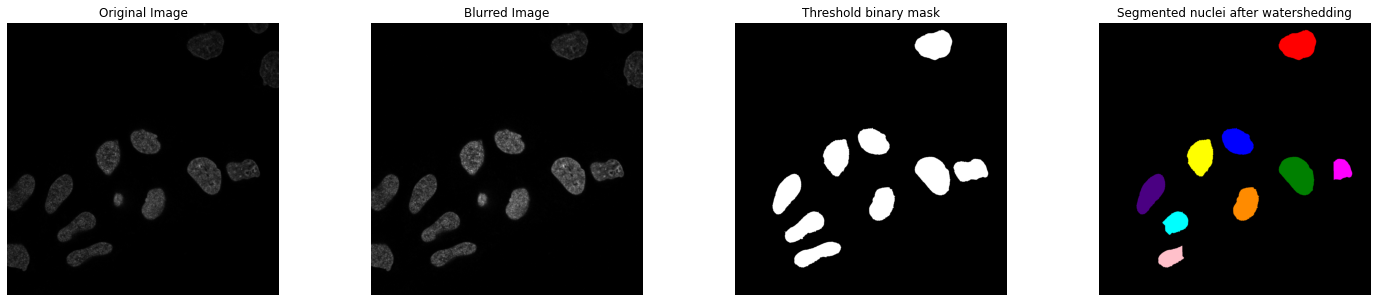

1802_plus_auxin_3h_stain_hoechst_scc1_halo-wapl-tmr_pos1-14 #09.tif


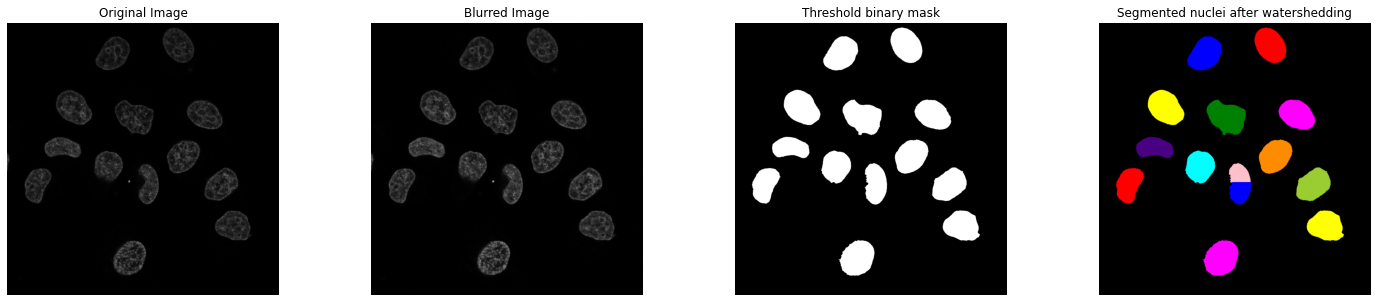

1802_plus_auxin_3h_stain_hoechst_scc1_halo-wapl-tmr_pos1-14 #10.tif


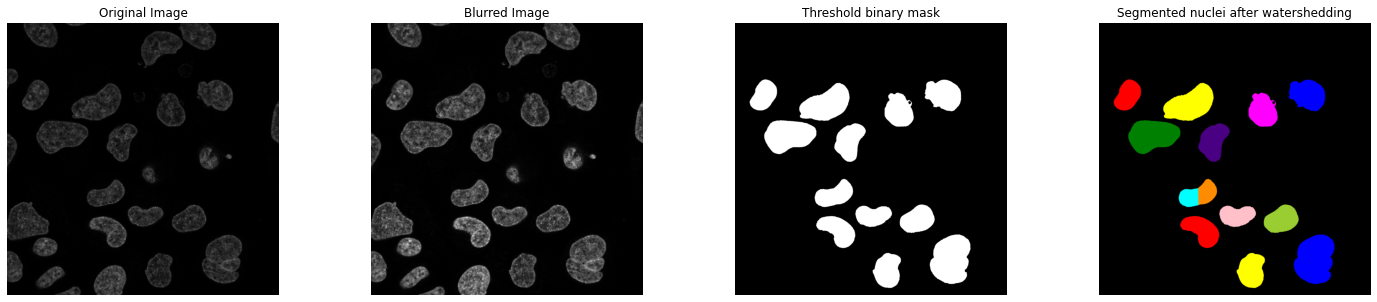

1802_plus_auxin_3h_stain_hoechst_scc1_halo-wapl-tmr_pos1-14 #12.tif


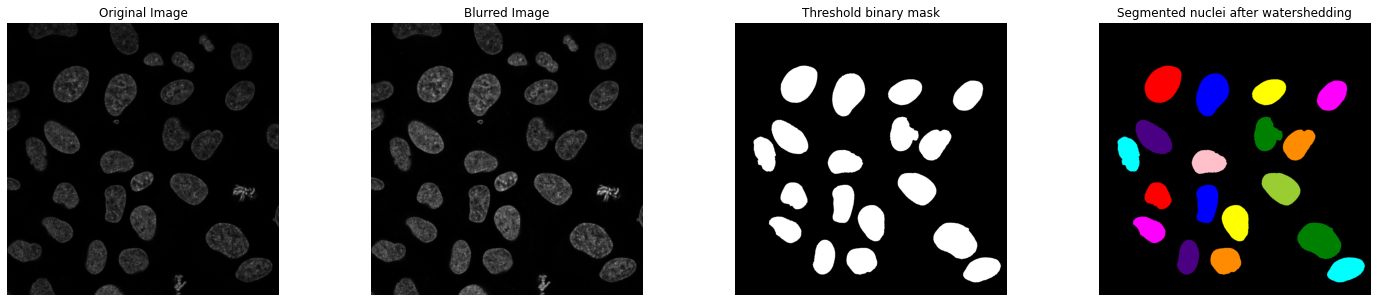

1802_plus_auxin_3h_stain_hoechst_scc1_halo-wapl-tmr_pos1-14 #13.tif


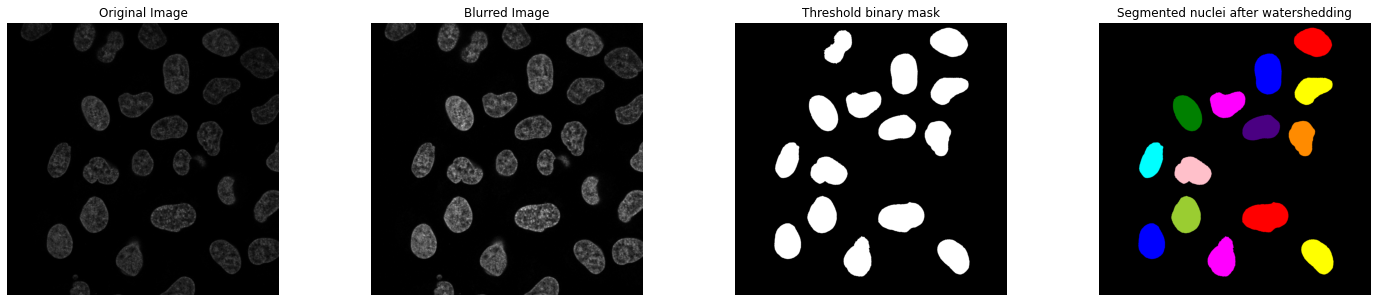

1802_plus_auxin_3h_stain_hoechst_scc1_halo-wapl-tmr_pos1-14 #14.tif


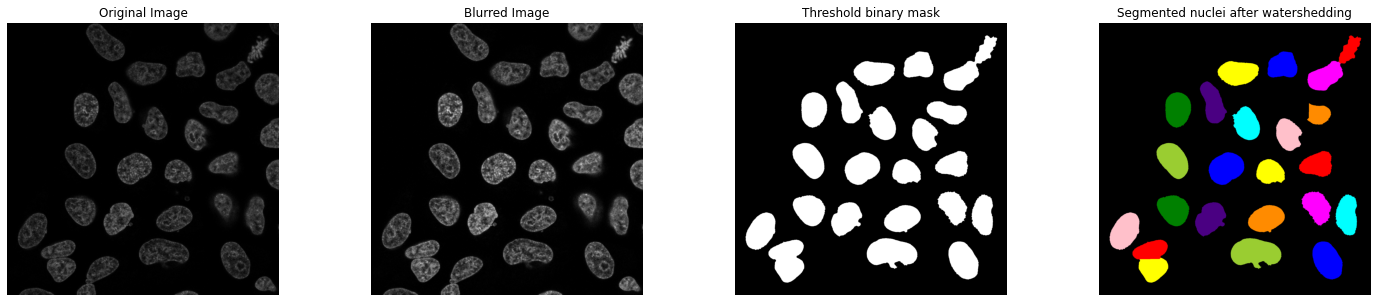

1802_plus_auxin_3h_stain_hoechst_scc1_halo-wapl-tmr_pos15-26 #01.tif


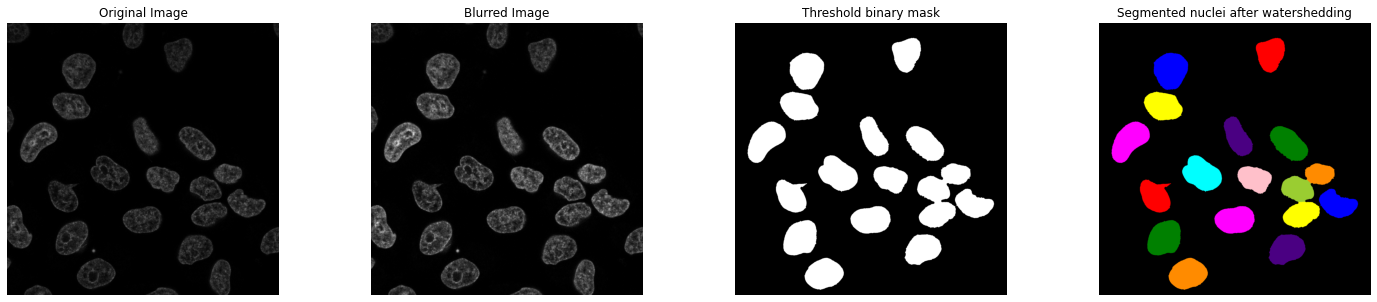

1802_plus_auxin_3h_stain_hoechst_scc1_halo-wapl-tmr_pos15-26 #02.tif


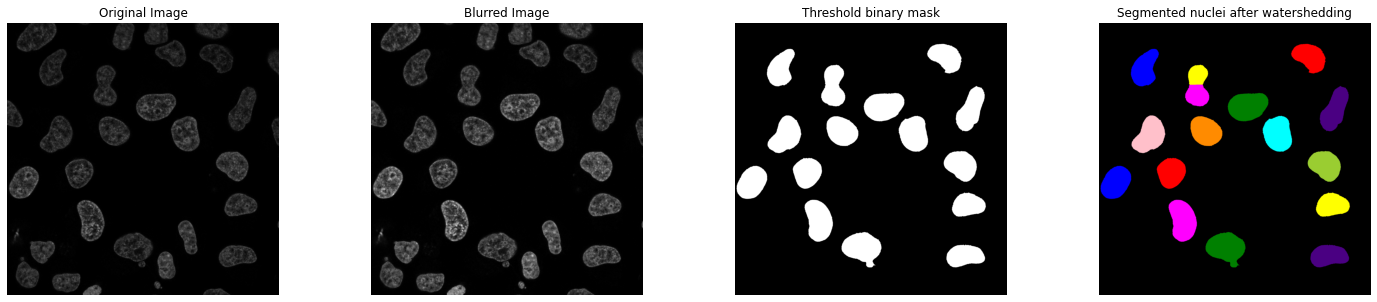

1802_plus_auxin_3h_stain_hoechst_scc1_halo-wapl-tmr_pos15-26 #03.tif


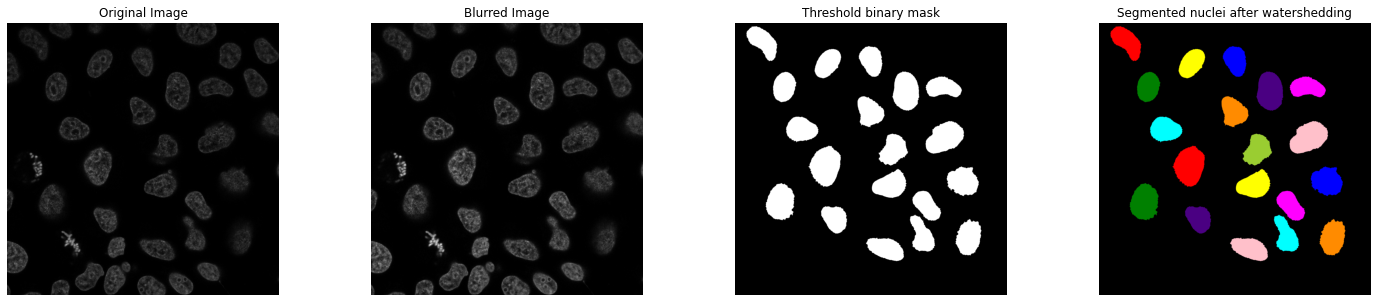

1802_plus_auxin_3h_stain_hoechst_scc1_halo-wapl-tmr_pos15-26 #04.tif


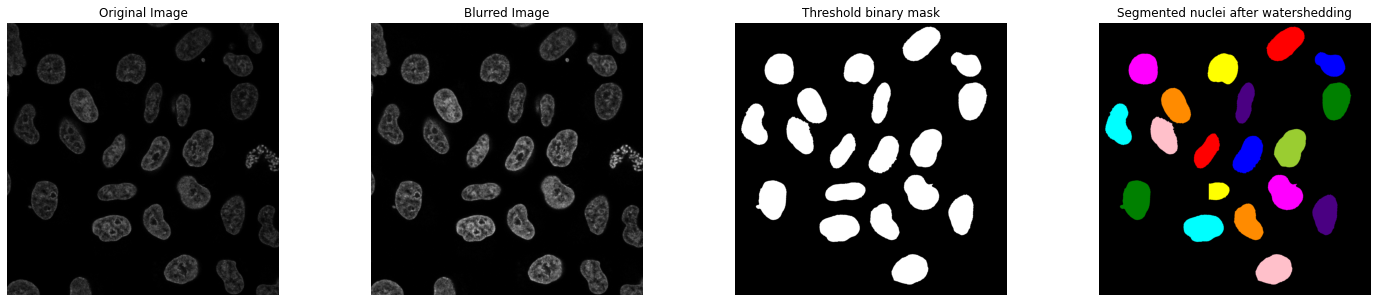

1802_plus_auxin_3h_stain_hoechst_scc1_halo-wapl-tmr_pos15-26 #05.tif


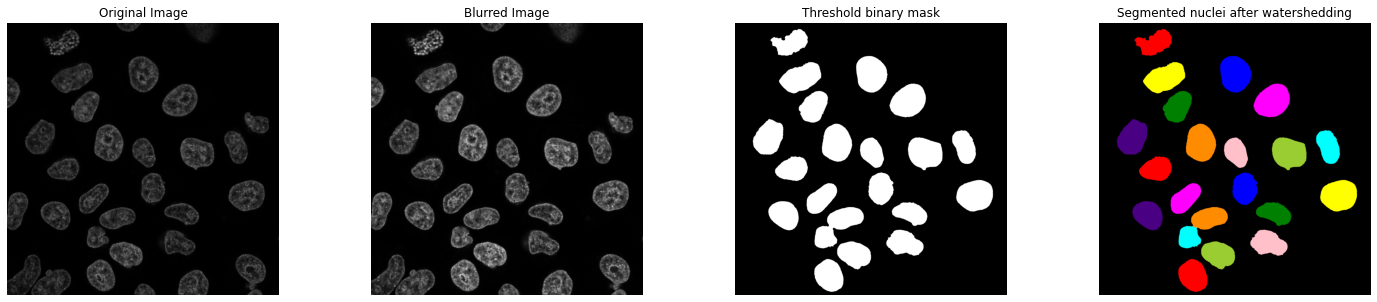

1802_plus_auxin_3h_stain_hoechst_scc1_halo-wapl-tmr_pos15-26 #06.tif


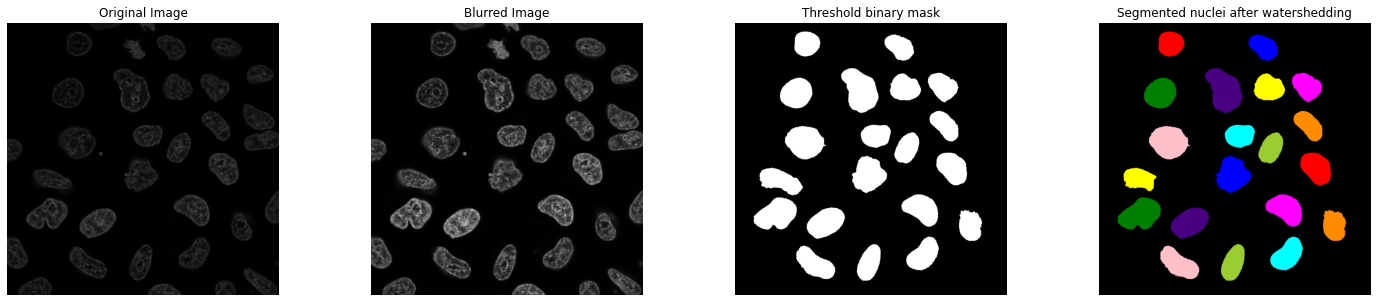

1802_plus_auxin_3h_stain_hoechst_scc1_halo-wapl-tmr_pos15-26 #07.tif


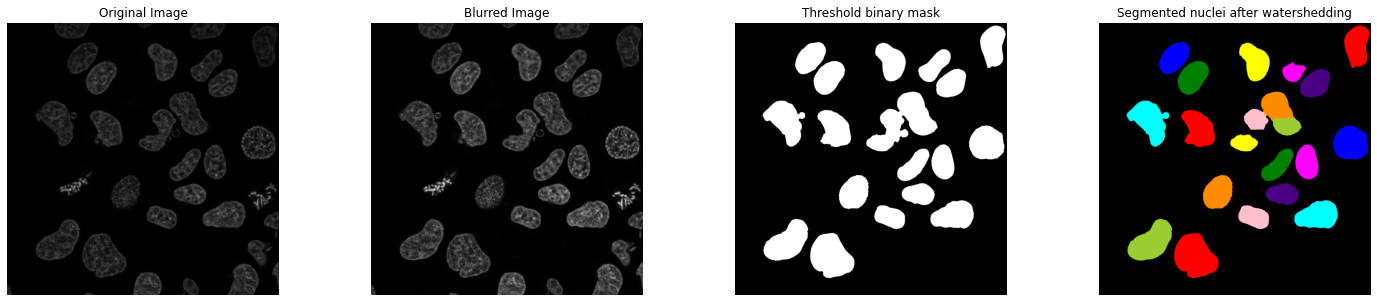

1802_plus_auxin_3h_stain_hoechst_scc1_halo-wapl-tmr_pos15-26 #08.tif


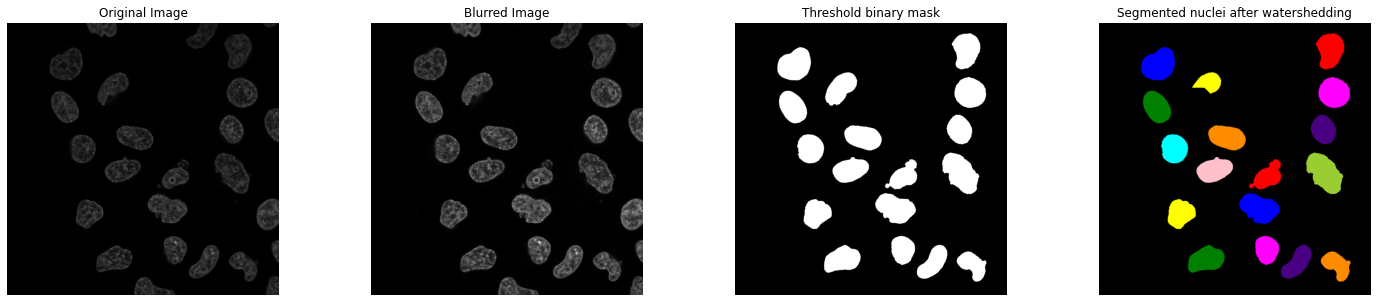

1802_plus_auxin_3h_stain_hoechst_scc1_halo-wapl-tmr_pos15-26 #09.tif


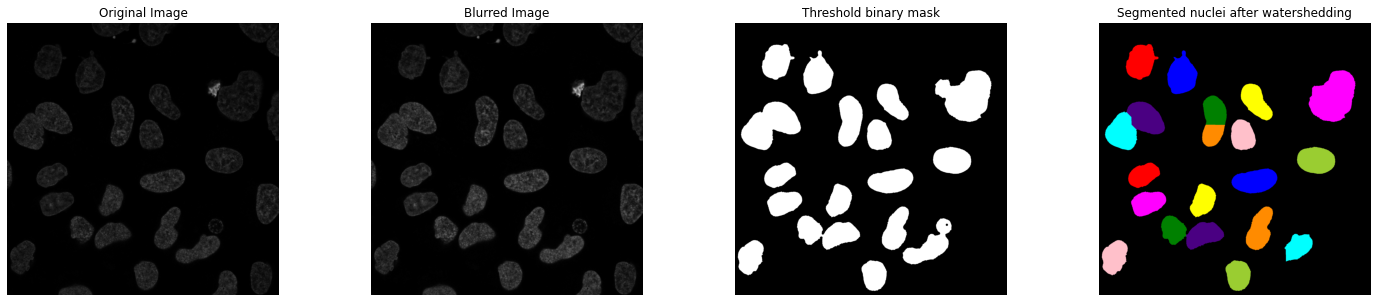

1802_plus_auxin_3h_stain_hoechst_scc1_halo-wapl-tmr_pos15-26 #10.tif


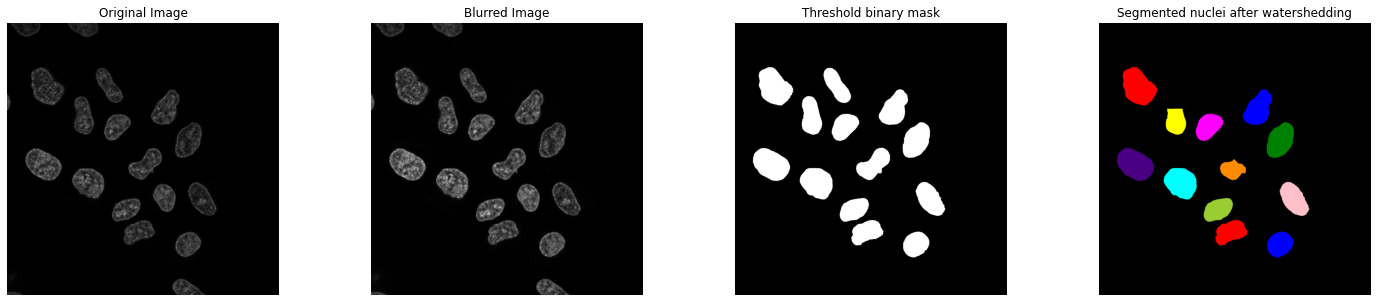

1802_plus_auxin_3h_stain_hoechst_scc1_halo-wapl-tmr_pos15-26 #11.tif


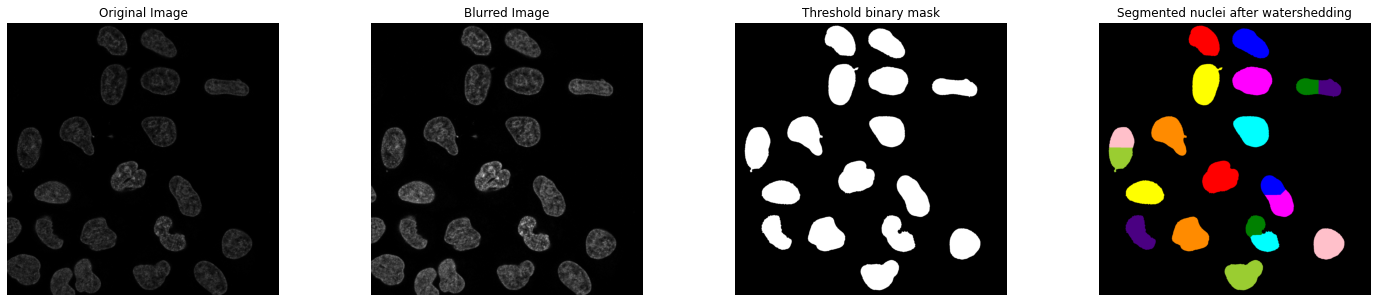

1802_plus_auxin_3h_stain_hoechst_scc1_halo-wapl-tmr_pos1-14 #01.tif


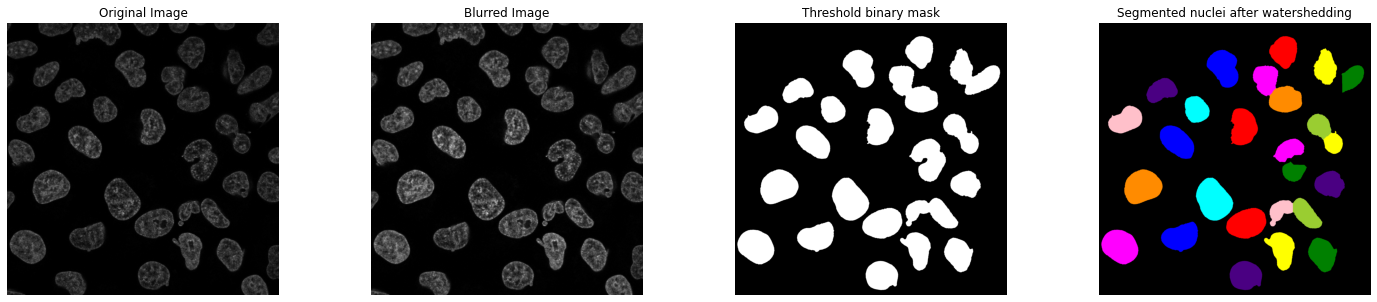

1802_plus_auxin_3h_stain_hoechst_scc1_halo-wapl-tmr_pos1-14 #03.tif


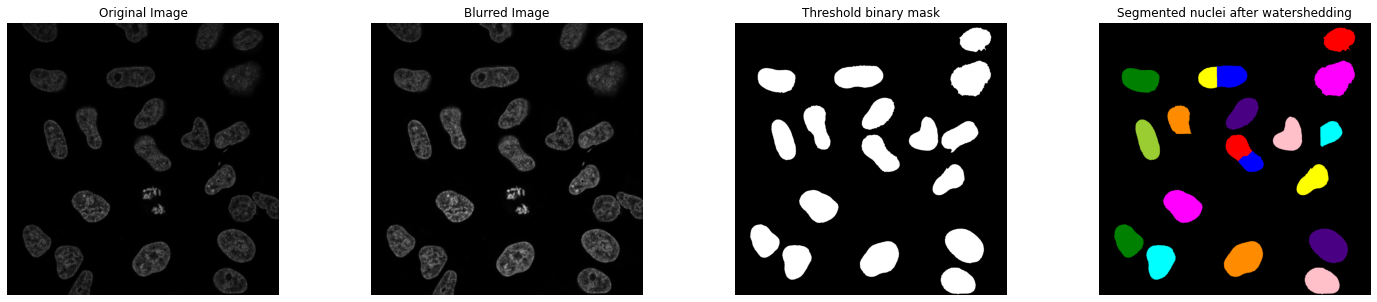

1802_plus_auxin_3h_stain_hoechst_scc1_halo-wapl-tmr_pos1-14 #04.tif


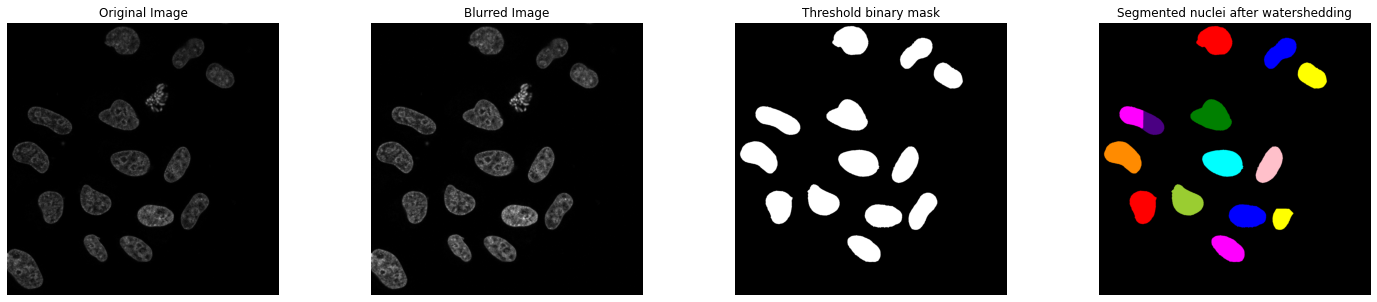

1802_plus_auxin_3h_stain_hoechst_scc1_halo-wapl-tmr_pos1-14 #06.tif


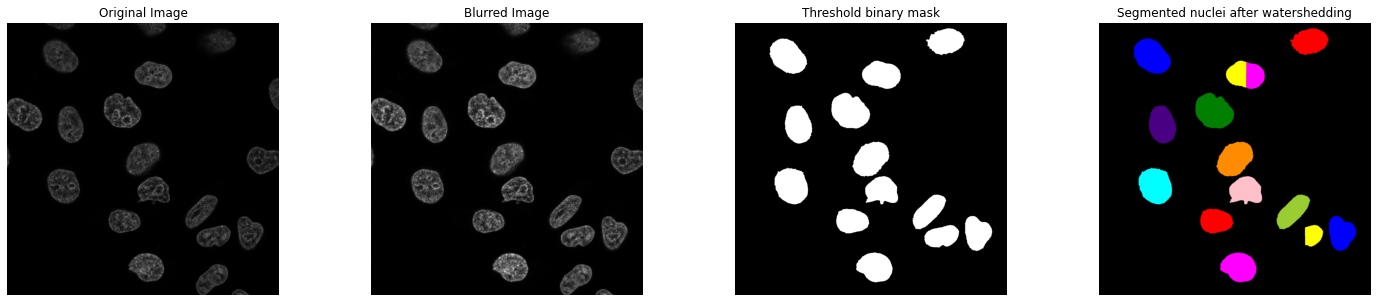

1802_plus_auxin_3h_stain_hoechst_scc1_halo-wapl-tmr_pos1-14 #07.tif


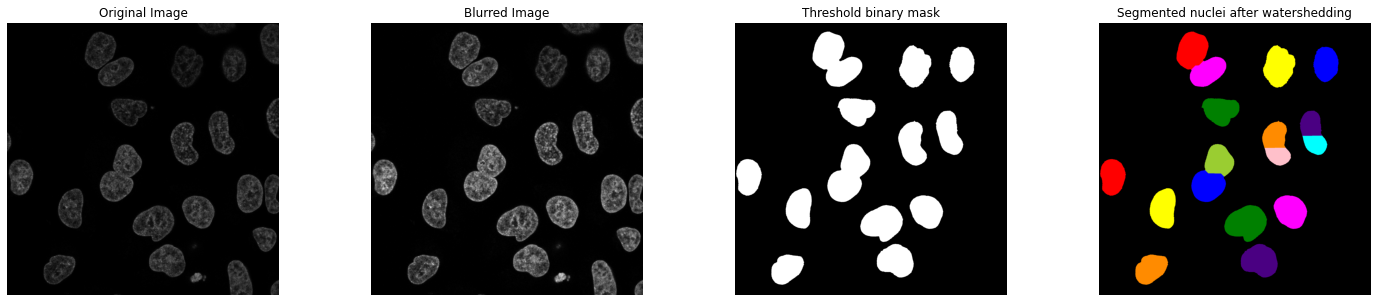

1802_plus_auxin_3h_stain_hoechst_scc1_halo-wapl-tmr_pos27-34 #5.tif


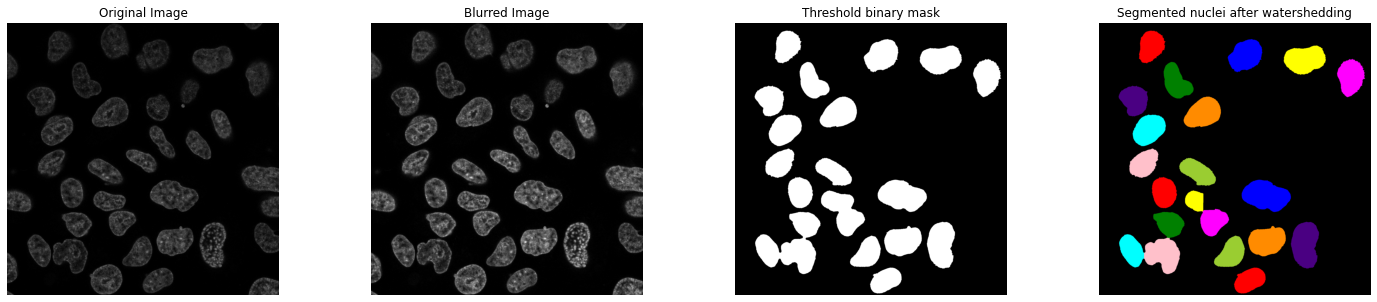

1802_plus_auxin_3h_stain_hoechst_scc1_halo-wapl-tmr_pos27-34 #6.tif


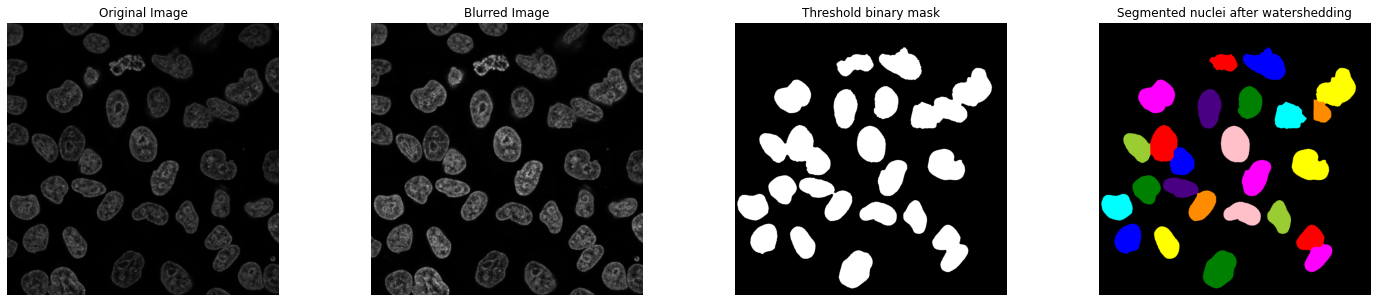

1802_plus_auxin_3h_stain_hoechst_scc1_halo-wapl-tmr_pos27-34 #8.tif


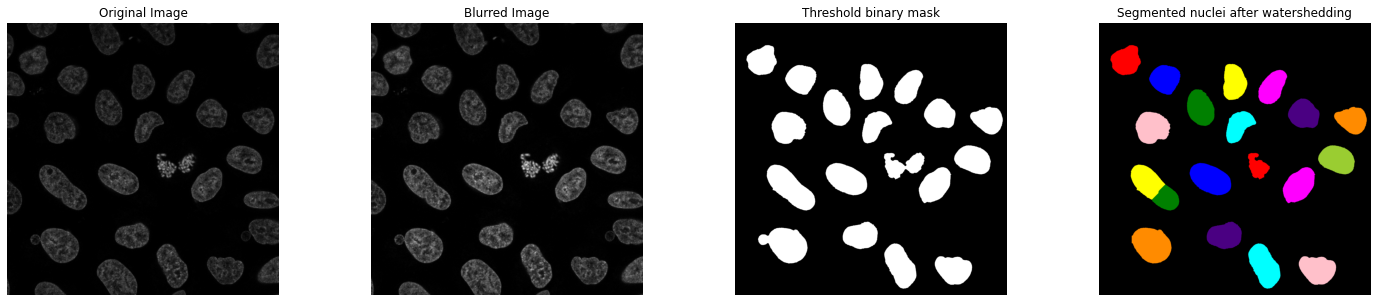

1802_plus_auxin_3h_stain_hoechst_scc1_halo-wapl-tmr_pos27-34 #1.tif


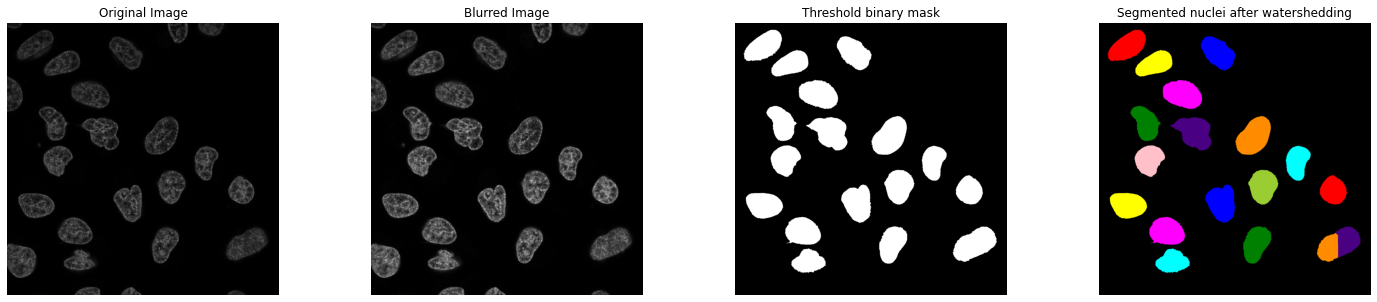

1802_plus_auxin_3h_stain_hoechst_scc1_halo-wapl-tmr_pos27-34 #2.tif


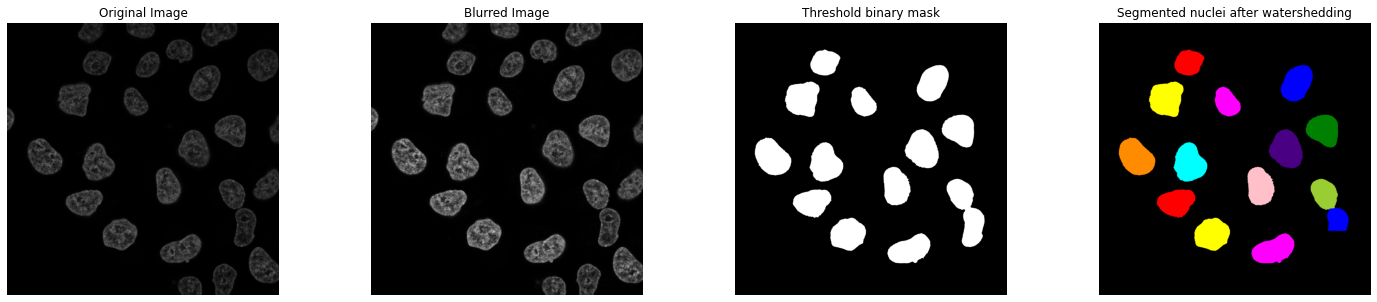

1802_plus_auxin_3h_stain_hoechst_scc1_halo-wapl-tmr_pos27-34 #3.tif


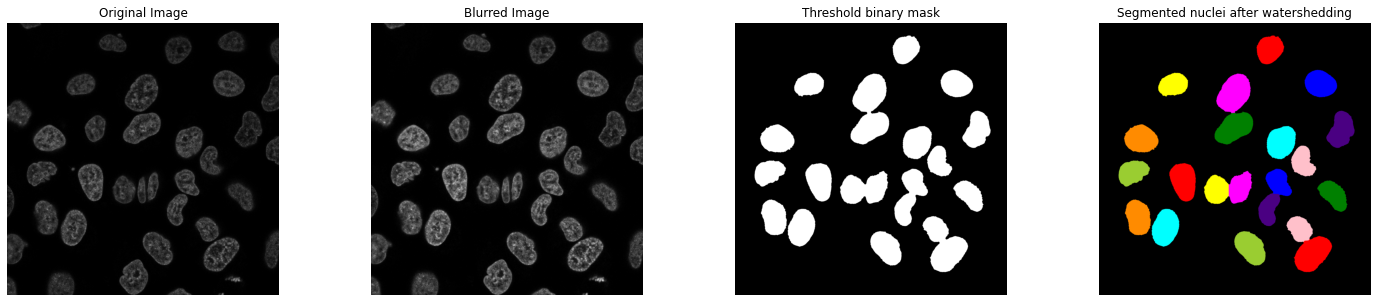

1802_plus_auxin_3h_stain_hoechst_scc1_halo-wapl-tmr_pos27-34 #4.tif


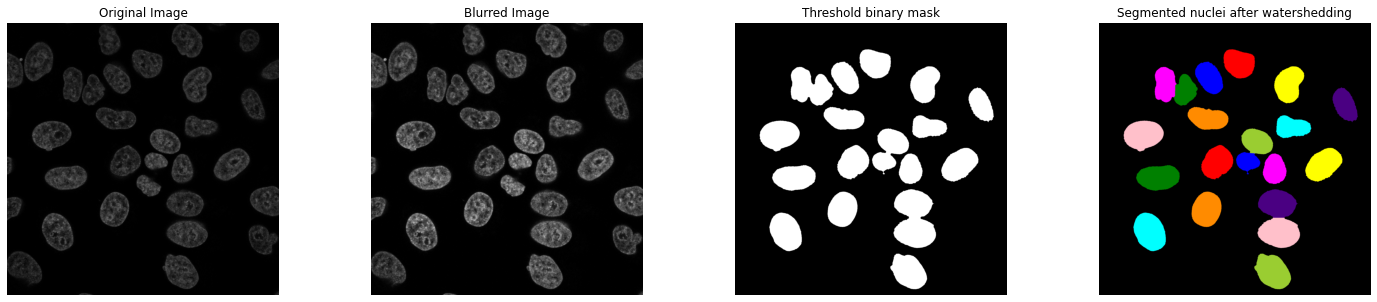

    nuclear_area_microns  mean_hoechst  mean_scc1  mean_wapl  total_hoechst  \
0             199.830565     12.990626  37.335527   9.239349    2595.924231   
1             153.172049     28.485478  44.984129  10.970469    4363.179060   
2             175.006800     26.857301  47.589297  11.896271    4700.210373   
3             230.707085     29.822850  45.813370  11.233832    6880.342758   
5             171.529579     21.542664  45.720638  13.591049    3695.204061   
..                   ...           ...        ...        ...            ...   
15            204.906908     20.965671  41.109161   7.424390    4296.010922   
16            201.200530     27.500371  44.338789   7.771318    5533.089303   
17            228.978438     25.597924  39.784266   7.575342    5861.372767   
18            240.371565     24.617169  38.063626   7.281010    5917.267338   
19            226.113966     24.305360  46.815660   7.450418    5495.781420   

    total_nuclear_scc1  total_nuclear_wapl  std_hoe

In [11]:
inpath = ("/groups/gerlich/experiments/Experiments_005600/005606/images/tifs/attempt1_220808/1802_plus_auxin/")
os.chdir(inpath)
images = glob('*.tif', recursive=True)
result = threshold_field(images)

#data = io.imread("/groups/gerlich/experiments/Experiments_005200/005223/Images/Projections/short_g2_scc1_smc4/2108_zoom5_0_control_short_G2_cycB1_SMC4_Scc1_EGFP_Hoechst-02-64.czi #1.tif_registered.tif")

In [12]:
result

nuclear_area_microns  mean_hoechst  mean_scc1  mean_wapl  total_hoechst  \
0             199.830565     12.990626  37.335527   9.239349    2595.924231   
1             153.172049     28.485478  44.984129  10.970469    4363.179060   
2             175.006800     26.857301  47.589297  11.896271    4700.210373   
3             230.707085     29.822850  45.813370  11.233832    6880.342758   
5             171.529579     21.542664  45.720638  13.591049    3695.204061   
..                   ...           ...        ...        ...            ...   
15            204.906908     20.965671  41.109161   7.424390    4296.010922   
16            201.200530     27.500371  44.338789   7.771318    5533.089303   
17            228.978438     25.597924  39.784266   7.575342    5861.372767   
18            240.371565     24.617169  38.063626   7.281010    5917.267338   
19            226.113966     24.305360  46.815660   7.450418    5495.781420   

    total_nuclear_scc1  total_nuclear_wapl  std_hoechst   std_scc1  \
0          7460.779486         1846.304300     7.901610  31.410037   
1          6890.311122         1680.369159    14.429438  40.324058   
2          8328.450545         2081.928314    14.958660  45.855206   
3         10569.469156         2591.724665    14.057579  39.050374   
5          7842.441767         2331.266923    11.157290  42.528668   
..                 ...                 ...          ...        ...   
15         8423.551024         1521.308752    11.655284  31.719851   
16         8920.987800         1563.593344    14.056523  33.417813   
17         9109.739085         1734.589883    14.078086  32.178234   
18         9149.413271         1750.147703    13.102137  31.153074   
19        10585.674597         1684.643450    11.835120  35.224792   

    coeff_variance_hoechst  coeff_variance_scc1      condition  
0                 0.608255             0.841291  1802_plus_aux  
1                 0.506554             0.896406  1802_plus_aux  
2                 0.556968             0.963561  1802_plus_aux  
3                 0.471369             0.852379  1802_plus_aux  
5                 0.517916             0.930185  1802_plus_aux  
..                     ...                  ...            ...  
15                0.555922             0.771601  1802_plus_aux  
16                0.511139             0.753693  1802_plus_aux  
17                0.549970             0.808818  1802_plus_aux  
18                0.532236             0.818447  1802_plus_aux  
19                0.486935             0.752415  1802_plus_aux  

[481 rows x 12 columns]

In [18]:
# Testing thresholding on single image using cellpose and napari

# To do, use command line and cell pose to apply thresholding to a folder of cells

In [19]:
data = io.imread("/groups/gerlich/experiments/Experiments_005600/005606/images/tifs/2096_minus_dtag/2096_minus_dtag_stain_hoechst_scc1_pos1-6 #06.tif")
#mask = io.imread("/groups/gerlich/experiments/Experiments_005000/005003/TIFs_registered_background_subtracted_testing/WT_fully_noR/Rep1/1/slices/20/Mask.tif")
print("shape: {}".format(data.shape))
print("dtype: {}".format(data.dtype))
print("range: ({}, {})".format(data.min(), data.max()))

#print("m shape: {}".format(mask.shape))
#print("m dtype: {}".format(mask.dtype))
#print("m range: ({}, {})".format(mask.min(), mask.max()))

FileNotFoundError: [Errno 2] No such file or directory: '/groups/gerlich/experiments/Experiments_005600/005606/images/tifs/2096_minus_dtag/2096_minus_dtag_stain_hoechst_scc1_pos1-6 #06.tif'

In [ ]:
hoechst = data[0,:,:]
scc1 = data[1,:,:]
#wapl_ha = data[:,:,2]
display_slice(hoechst)
